In [2]:
import pandas as pd
import numpy as np
import scipy.stats
from  scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import math
import os

In [3]:
plt.rcParams['figure.figsize'] = [10,8]

In [4]:
root = "D:\ShenLab\Cytometry\omiq_exported_data_processed"

We test our codes on the file "01.T1_Normalized.csv".

In [5]:
data1_T1 = pd.read_csv(os.path.join(root, "01.T1_Normalized.csv"))

Extract the columns we need: `Ir191Di___191Ir_DNA1`, `Event_length`, and `gate1_ir`.

In [6]:
gate1_1_T1 = data1_T1[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
gate1_1_T1.head()

,Ir191Di___191Ir_DNA1,Event_length,gate1_ir
0,6.9935,36,1
1,5.5613,26,0
2,7.9067,32,1
3,7.0526,27,1
4,6.7595,36,1


Break the above table into two, one containing data points inside of `gate1_ir`, and the other containing data points outside of `gate1_ir`.

In [7]:
in_gate1 = gate1_1_T1[gate1_1_T1['gate1_ir'] == 1]
out_gate1 = gate1_1_T1[gate1_1_T1['gate1_ir'] == 0]

In [8]:
in_gate1 = in_gate1.to_numpy()
out_gate1 = out_gate1.to_numpy()

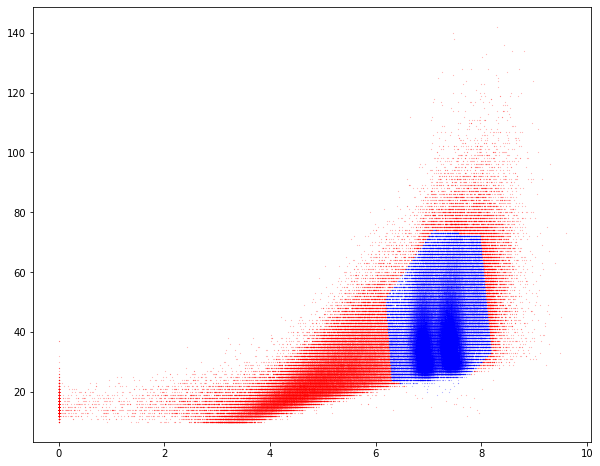

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(in_gate1[:,0], in_gate1[:,1], s=0.01, c='b')
ax1.scatter(out_gate1[:,0], out_gate1[:,1], s=0.01, c='r')
plt.show()

We wrap the plotting code into a function below.

In [10]:
def plot_gate1(filename):
    """Plot gate 1 for the deignated csv file.
       The x-axis is Ir191Di___191Ir_DNA1, the y-axis is Event_length. Data points
       inside gate 1 are coloured blue, and those outside gate 1 are coloured red."""
    data = pd.read_csv(os.path.join(root, filename + ".csv"))
    gate1 = data[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
    in_gate1 = gate1[gate1['gate1_ir'] == 1]
    out_gate1 = gate1[gate1['gate1_ir'] == 0]
    in_gate1 = in_gate1.to_numpy()
    out_gate1 = out_gate1.to_numpy()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(in_gate1[:,0], in_gate1[:,1], s=0.01, c='b')
    ax1.scatter(out_gate1[:,0], out_gate1[:,1], s=0.01, c='r')
    plt.show()

The following function saves the plot for gate1 without showing it in notebook.

In [11]:
def save_plot_gate1(filename):
    """Plot gate 1 for the deignated csv file and save the image.
       The x-axis is Ir191Di___191Ir_DNA1, the y-axis is Event_length. Data points
       inside gate 1 are coloured blue, and those outside gate 1 are coloured red."""
    data = pd.read_csv(os.path.join(root, filename + ".csv"))
    gate1 = data[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
    in_gate1 = gate1[gate1['gate1_ir'] == 1]
    out_gate1 = gate1[gate1['gate1_ir'] == 0]
    in_gate1 = in_gate1.to_numpy()
    out_gate1 = out_gate1.to_numpy()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(in_gate1[:,0], in_gate1[:,1], s=0.01, c='b')
    ax1.scatter(out_gate1[:,0], out_gate1[:,1], s=0.01, c='r')
    plt.savefig("plots/" + filename + "_gate1.png")
    plt.close(fig)

Now we iterate through all the .csv files and save a gate1 plot for each of them.

In [47]:
for filename in os.listdir(root):
    f = filename[:-4]
    save_plot_gate1(f)

Instead of plotting the data points directly, we try something different.

In [12]:
def global_extrema(dir_name):
    """Return the global maxima and minima of Ir191Di___191Ir_DNA1 and Event_length
       in all the files under the given directory."""
    def local_extrema(filename):
        data = pd.read_csv(os.path.join(dir_name, filename))
        ir191 = data["Ir191Di___191Ir_DNA1"]
        el = data["Event_length"]
        return (ir191.max(), ir191.min(), el.max(), el.min())
    ir191_max, el_max = -math.inf, -math.inf
    ir191_min, el_min = math.inf, math.inf
    # for each file in the directory, we extract the relavant maxima and minima
    for file in os.listdir(dir_name):
        ir191_max_l, ir191_min_l, el_max_l, el_min_l = local_extrema(file)
        ir191_max = max(ir191_max, ir191_max_l)
        ir191_min = min(ir191_min, ir191_min_l)
        el_max = max(el_max, el_max_l)
        el_min = min(el_min, el_min_l)
    return (ir191_max, ir191_min, el_max, el_min)

In [57]:
ir191_max, ir191_min, el_max, el_min = global_extrema(root)
print(ir191_max, ir191_min, el_max, el_min)

10.263 0.0 174 10


Each Ir191 value in the given dataset is precise to 1/10000, that will make the images too large for computing. Therefore, we first resize the axis to resize the images to managable size.

In [58]:
test_data = pd.read_csv(os.path.join(root, "01.T1_Normalized.csv"))[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
test_data = test_data.to_numpy()
print(test_data.shape)

(351332, 3)


In [13]:
def convert_to_image(filename):
    """Read a file and output a greyscale image representing gate 1.
       The output image is a numpy array of shape (165, 165, 1)."""
    image = np.zeros((165, 165, 1))
    data = pd.read_csv(os.path.join(root, filename))[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
    data = data.to_numpy()
    for cell in data:
        ir191, el, gate1 = cell
        ir191 = int(ir191 * 10000 // 622)
        el, gate1 = int(el - 10), int(gate1)
        if gate1 == 0:
            image[ir191, el, 0] = 128
        elif gate1 == 1:
            image[ir191, el, 0] = 255
    return image

In [14]:
test_image = convert_to_image("01.T1_Normalized.csv")

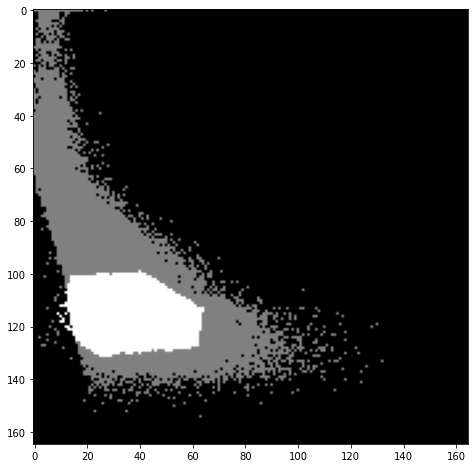

In [15]:
plt.imshow(test_image, cmap="gray")

Now that we have a way of converting the data points to a proper image form for analysis, we need to obtain the location information of the region of interest. To achineve this, we compute the ROI as the convex hull of the in-gate data points.

In [47]:
def test_convex_hull(filename):
    data = pd.read_csv(os.path.join(root, filename))
    gate1 = data[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
    in_gate1 = gate1[gate1['gate1_ir'] == 1]
    in_gate1 = in_gate1[["Ir191Di___191Ir_DNA1", "Event_length"]].to_numpy()
    hull = ConvexHull(in_gate1)
    return in_gate1, hull

In [48]:
test_in_gate1, test_hull = test_convex_hull("01.T1_Normalized.csv")

In [49]:
print(len(test_hull.vertices))
print(test_hull.vertices)

24
[204413   7979 196014   7108  66103 194476  18367   7229 129894   1410
  11155 116199 143837  51489 211152  22480  62897  77927 194249 126979
  40619  90691 185973 185120]


In [61]:
# The following code returns the list of vertex coordinates
def vertex_coords(vertices, in_gate):
    """Returns a list of vertex coordinates.
       Input: the vertices attribute of a convex hull
              the array of data points whose convex hull was computed
       Return: a list of coordinates corresponding to the vertices"""
    coords = []
    for vertex in vertices:
        coords.append(tuple(in_gate[vertex]))
    return coords

In [62]:
vertices = vertex_coords(test_hull.vertices, test_in_gate1)

In [63]:
print(vertices)

[(6.2797, 26.0), (6.2899, 24.0), (6.4443, 23.0), (6.9773, 20.0), (7.1692, 19.0), (7.3924, 20.0), (7.8544, 27.0), (7.9084, 28.0), (8.1758, 33.0), (8.1897, 34.0), (8.1791, 36.0), (7.9821, 72.0), (7.5696, 73.0), (7.1434, 74.0), (7.0835, 74.0), (7.0393, 73.0), (6.9983, 72.0), (6.7983, 67.0), (6.2856, 54.0), (6.2477, 53.0), (6.2099, 52.0), (6.182, 51.0), (6.208, 44.0), (6.2119, 43.0)]


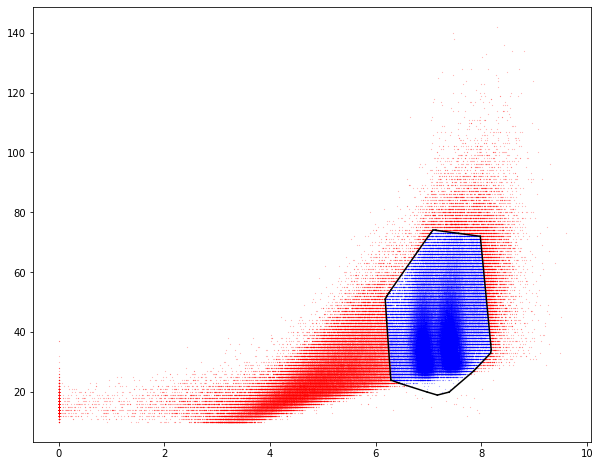

In [46]:
# The following code plots the gate on the original scatter plot
data1_T1 = pd.read_csv(os.path.join(root, "01.T1_Normalized.csv"))
gate1_1_T1 = data1_T1[["Ir191Di___191Ir_DNA1", "Event_length", "gate1_ir"]]
in_gate1 = gate1_1_T1[gate1_1_T1['gate1_ir'] == 1]
out_gate1 = gate1_1_T1[gate1_1_T1['gate1_ir'] == 0]
in_gate1 = in_gate1.to_numpy()
out_gate1 = out_gate1.to_numpy()
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(in_gate1[:,0], in_gate1[:,1], s=0.01, c='b')
ax1.scatter(out_gate1[:,0], out_gate1[:,1], s=0.01, c='r')
for simplex in test_hull.simplices:
    plt.plot(in_gate1[simplex, 0], in_gate1[simplex, 1], 'k-')
plt.show()

A problem:  
The data points are not perfectly continuous, thus although the original gate is clearly a heptagon, ConvexHull usually gives a lot more than seven vertices. Many of these "vertices" lie on one side of the heptagon, hence our task now is to get rid of these false vertices. The `vertices` attribute of the convex hull lists all the vertices (including the false ones) in anti-clockwise order, so the idea is to check every triple of adjacent vertices, if they lie roughly on the same line, then we delete the middle vertex. We repeat the procedure until there are no vertices to remove any more.

In [116]:
def vertex_reduce(vertices, final_num):
    """Get rid of the false vertices and return only the true vertices.
       input: - a list of all the vertices of the convex hull
              - final number of vertices we want to reduce to
       return: - a list of the true vertices"""
    vertex_slope_diff = {}
    num_vertices = len(vertices)
    for j in range(num_vertices):
        i, k = (j - 1) % num_vertices, (j + 1) % num_vertices
        slope1 = (vertices[j][1] - vertices[i][1]) / (vertices[j][0] - vertices[i][0])
        slope2 = (vertices[k][1] - vertices[j][1]) / (vertices[k][0] - vertices[j][0])
        vertex_slope_diff[abs(slope1 - slope2)] = j
    vertex_slope_diff = dict(sorted(vertex_slope_diff.items()))
    reduced_vertices_idx = list(vertex_slope_diff.values())[-final_num:]
    reduced_vertices = []
    for idx in reduced_vertices_idx:
        reduced_vertices.append(vertices[idx])
    return reduced_vertices

In [125]:
r_v = vertex_reduce(vertices, 10)

In [126]:
print(r_v)

[(7.1692, 19.0), (7.3924, 20.0), (6.208, 44.0), (7.0835, 74.0), (8.1758, 33.0), (6.2797, 26.0), (7.9821, 72.0), (6.2899, 24.0), (8.1897, 34.0), (6.182, 51.0)]


In [129]:
r_v = np.asarray(r_v)

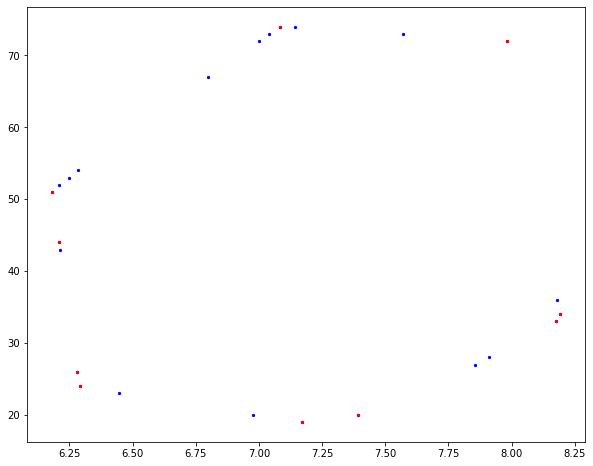

In [128]:
vertices_array = np.asarray(vertices)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(vertices_array[:,0], vertices_array[:,1], s=5, c='b')
ax2.scatter(r_v[:,0], r_v[:,1], s=5, c='r')